In [1]:
include("../src/include_file.jl");

In [2]:
Nx = 10
xmin, xmax = 0.0, 1.0
CFL_factor = 0.5
equation = SaintVenant(flat_zb(height=0.0), 1e-10)
method = createHydrostatic(CFL_factor, Rusanov)
boxBounds=[5.0 10;-5.0 5.0]
sourceBounds=[-5.0, 5.0]
nb_it = 1

dx = (xmax - xmin) / Nx
p = get_unknowns_number(equation)
sL, sR = get_sL(method), get_sR(method)
modifiedDataType = meanK(sL, sR)
boundsType = NormalBounds()

domain = createInterval(0.0, dx*(2*sL+2*sR+3), 2*sL+2*sR+3, 0.0, 1.0)
@show domain
initDataMat, worstDataMat, worstLowDiffVec = zeros((nb_it, sL+sR+1, p)), zeros((nb_it, sL+sR+1, p)), zeros(nb_it)
initSource, worstSource = [], [];

domain = Interval(0.0, 0.7000000000000001, 7, 0.0, 1.0, 0.1, Real[0.0, 0.11666666666666667, 0.23333333333333334, 0.35000000000000003, 0.4666666666666667, 0.5833333333333334, 0.7000000000000001], Real[-0.05, 0.06428571428571428, 0.17857142857142858, 0.29285714285714287, 0.4071428571428572, 0.5214285714285716, 0.6357142857142858, 0.7500000000000001], nothing, nothing)


In [3]:
initDataMat, worstDataMat, worstLowDiffVec = zeros((nb_it, sL+sR+1, p)), zeros((nb_it, sL+sR+1, p)), zeros(nb_it)
initSource, worstSource = [], [];

k = 1

domain.sourceVec = nothing

# Generating a random componentwise constant initial data inside the specified bounds
u_init = zeros((sL+sR+1, p))
u_low, u_up = zero(u_init), zero(u_init)
for i in 1:p
    for k in 1:sL+sR+1
        u_init[k,i] = boxBounds[i,1] + (boxBounds[i,2] - boxBounds[i,1])*rand()
        u_low[k,i], u_up[k,i] = boxBounds[i,1], boxBounds[i,2]
    end
end
initDataMat[k,:,:] = u_init

@show u_init = reshape(u_init, (sL+sR+1)*p)
u_low, u_up = reshape(u_low, (sL+sR+1)*p), reshape(u_up, (sL+sR+1)*p)

z_init = zeros(sL+sR+1)
z_low, z_up = zeros(sL+sR+1) .+ sourceBounds[1], zeros(sL+sR+1) .+ sourceBounds[2]
for i in eachindex(z_init)
    z_init[i] += sourceBounds[1] + rand()*(sourceBounds[2] - sourceBounds[1])
end
@show z_init
@show uz_init, uz_low, uz_up = vcat(u_init, z_init), vcat(u_low, z_low), vcat(u_up, z_up)

length(uz_init) > (sL+sR+1)*p ? push!(initSource, uz_init[(sL+sR+1)*p+1:end]) : push!(initSource, nothing)


u_init = reshape(u_init, (sL + sR + 1) * p) = [7.504188093336849, 6.66837829679298, 5.275783678263935, -1.1278076848953065, 2.236605488713826, 4.372241221577079]
z_init = [4.374070168054288, 2.599588640164664, 4.095271887381056]
(uz_init, uz_low, uz_up) = (vcat(u_init, z_init), vcat(u_low, z_low), vcat(u_up, z_up)) = ([7.504188093336849, 6.66837829679298, 5.275783678263935, -1.1278076848953065, 2.236605488713826, 4.372241221577079, 4.374070168054288, 2.599588640164664, 4.095271887381056], [5.0, 5.0, 5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0], [10.0, 10.0, 10.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0])


1-element Vector{Any}:
 [4.374070168054288, 2.599588640164664, 4.095271887381056]

In [4]:
@show initDataMat
@show initSource

initDataMat = [7.504188093336849 6.66837829679298 5.275783678263935;;; -1.1278076848953065 2.236605488713826 4.372241221577079]
initSource = Any[[4.374070168054288, 2.599588640164664, 4.095271887381056]]


1-element Vector{Any}:
 [4.374070168054288, 2.599588640164664, 4.095271887381056]

In [5]:
@show uz_unk = uz_init

p = get_unknowns_number(equation)
@show Nx = domain.Nx
sL, sR = get_sL(method), get_sR(method)
@show j = sL + sR + 1

# Reconstructing u from the given data
u = zeros(Nx,p)
u_unk = reshape(uz_unk[1:p*(sL+sR+1)], (sL+sR+1,p))
# for k in sR+1:sL+2*sR+1
#     u[k,:] .= u_unk[k-sR,:]
# end
K = computeK(modifiedDataType, extractLocalData(u_unk, sL+1, sL, sR))
for k in 1:Nx
    if sR+2 ≤ k ≤ sL+2*sR+2
        u[k,:] .= u_unk[k-sR-1,:]
    else
        u[k,:] = K
    end
end
@show u

# Reconstructing the source from the given data
if length(uz_unk) > p*(sL+sR+1)
    zVec = zeros(Nx,1)
    Z = computeK(modifiedDataType, extractLocalData(reshape(uz_unk[p*(sL+sR+1)+1:end,:], (sL+sR+1,1)), sL+1, sL, sR))
    for k in 1:Nx
        if sR+2 ≤ k ≤ sL+2*sR+2
            zVec[k,:] .= uz_unk[p*(sL+sR+1) + k-sR-1]
        else
            zVec[k,:] = Z
        end
    end
    @show domain.sourceVec = zVec
end

uz_unk = uz_init = [7.504188093336849, 6.66837829679298, 5.275783678263935, -1.1278076848953065, 2.236605488713826, 4.372241221577079, 4.374070168054288, 2.599588640164664, 4.095271887381056]
Nx = domain.Nx = 7
j = sL + sR + 1 = 3
u = [5.972080987528457 3.3044233551454525; 5.972080987528457 3.3044233551454525; 7.504188093336849 -1.1278076848953065; 6.66837829679298 2.236605488713826; 5.275783678263935 4.372241221577079; 5.972080987528457 3.3044233551454525; 5.972080987528457 3.3044233551454525]
domain.sourceVec = zVec = [3.34743026377286; 3.34743026377286; 4.374070168054288; 2.599588640164664; 4.095271887381056; 3.34743026377286; 3.34743026377286;;]


7×1 Matrix{Float64}:
 3.34743026377286
 3.34743026377286
 4.374070168054288
 2.599588640164664
 4.095271887381056
 3.34743026377286
 3.34743026377286

In [6]:
u_mid = u[j,:]
dx = domain.dx
dt = method.CFL_factor * dx / CFL_cond(equation, u) # Timestep given by CFL condition
z = isnothing(domain.sourceVec) ? zeros((Nx, 1)) : reshape(domain.sourceVec, (domain.Nx,1))

# Computing mj-1/2 and Mj-1/2

@show ut = compute_u_tilde(modifiedDataType, u, j-1, sL, sR)
@show zt = isnothing(domain.sourceVec) ? zero(ut) : compute_u_tilde(modifiedDataType, z, j-1, sL, sR)
@show uh = compute_u_hat(equation.source, ut, dx, dt, j-1, domain, equation, method; zt=zt)

mminus, Mminus = initBounds(modifiedDataType, equation, u, j-1, sL, sR, z)
mminus, Mminus = updateBounds!(modifiedDataType, boundsType, equation, mminus, Mminus, ut, uh, j-1, sL, sR, Nx, dx, dt, zt)

if (mminus[1] > Mminus[1]) && warningsOn
    @warn "m-1/2 greater than M-1/2 !!!"
end

# Computing mj+1/2 and Mj+1/2

@show ut = compute_u_tilde(modifiedDataType, u, j, sL, sR)
@show zt = isnothing(domain.sourceVec) ? zero(ut) : compute_u_tilde(modifiedDataType, z, j, sL, sR)
@show uh = compute_u_hat(equation.source, ut, dx, dt, j, domain, equation, method; zt=zt)

up_mid = scheme_step(equation.source, u, dt, domain, equation, method)[j,:]

mplus, Mplus = initBounds(modifiedDataType, equation, u, j, sL, sR, z)
mplus, Mplus = updateBounds!(modifiedDataType, boundsType, equation, mplus, Mplus, ut, uh, j, sL, sR, Nx, dx, dt, zt)

if Mplus[1] - mplus[1] < -1e-10 && warningsOn
    @warn "m+1/2 greater than M+1/2 !!!"
    @show Mplus[1] - mplus[1]
end

@show worstLowDiffVec[1] = min(get_eta(equation, u_mid; z=z)[1] - dt/dx *(mplus[1] - Mminus[1]) - get_eta(equation, up_mid; z=z)[1], Mplus[1] - mplus[1])
worstData = uz_unk
worstDataMat[1,:,:] = reshape(worstData[1:(sL+sR+1)*p], (sL+sR+1, p))
length(worstData) > (sL+sR+1)*p ? push!(worstSource, worstData[(sL+sR+1)*p+1:end]) : push!(worstSource, nothing)

ut = compute_u_tilde(modifiedDataType, u, j - 1, sL, sR) = [6.738134540432654 1.088307835125073; 5.972080987528457 3.3044233551454525; 7.504188093336849 -1.1278076848953065; 6.738134540432654 1.088307835125073; 6.738134540432654 1.088307835125073; 6.738134540432654 1.088307835125073; 6.738134540432654 1.088307835125073]
zt = if isnothing(domain.sourceVec)
        zero(ut)
    else
        compute_u_tilde(modifiedDataType, z, j - 1, sL, sR)
    end = [3.8607502159135745; 3.34743026377286; 4.374070168054288; 3.8607502159135745; 3.8607502159135745; 3.8607502159135745; 3.8607502159135745;;]
uh = compute_u_hat(equation.source, ut, dx, dt, j - 1, domain, equation, method; zt = zt) = [6.379000688907669 3.69487288273939; 6.98717647989643 -0.39713444658368857; 6.594250917864022 -1.5959915056490035; 6.992110075062493 3.0202678837668375; 6.738134540432654 1.088307835125073; 6.738134540432654 1.088307835125073; 6.738134540432654 1.088307835125073]
ut = compute_u_tilde(modifiedDataType, u, j, sL, s

1-element Vector{Any}:
 [4.374070168054288, 2.599588640164664, 4.095271887381056]

In [7]:
@show worstDataMat
@show worstSource

worstDataMat = [7.504188093336849 6.66837829679298 5.275783678263935;;; -1.1278076848953065 2.236605488713826 4.372241221577079]
worstSource = Any[[4.374070168054288, 2.599588640164664, 4.095271887381056]]


1-element Vector{Any}:
 [4.374070168054288, 2.599588640164664, 4.095271887381056]

In [8]:
wd = WorstData(initDataMat, initSource, worstDataMat, worstLowDiffVec, worstSource, equation, method, domain, modifiedDataType)
i = argmin(wd.worstLowDiffVec)
p = get_unknowns_number(wd.equation)
sL, sR = get_sL(wd.method), get_sR(wd.method)
u_init, z = zeros(Nx, p), zeros(Nx, 1)
j = Int(round(Nx/2))

K = computeK(wd.modifiedDataType, extractLocalData(wd.worstDataMat[i,:,:], sL+1, sL, sR))
Z = isnothing(wd.domain.sourceVec) ? zeros(1,p) : computeK(wd.modifiedDataType, extractLocalData(reshape(wd.worstSource[i], (sL+sR+1,1)), sL+1, sL, sR))

for k in 1:Nx
    if j-sL ≤ k ≤ j+sR
        u_init[k,:] = wd.worstDataMat[i,k-j+sL+1,:]
        z[k,:] .= isnothing(wd.domain.sourceVec) ? 0.0 : wd.worstSource[i][k-j+sL+1]
    else
        u_init[k,:] = K
        z[k,:] = Z 
    end
end

z = isnothing(wd.domain.sourceVec) ? nothing : z

u_init, z

MethodError: MethodError: no method matching WorstData(::Array{Float64, 3}, ::Vector{Any}, ::Array{Float64, 3}, ::Vector{Float64}, ::Vector{Any}, ::SaintVenant, ::Hydrostatic, ::Interval, ::CLModifiedData)

Closest candidates are:
  WorstData(::Any, ::Any, ::Any, ::Any, ::Any, ::Equation, ::FVMethod, ::Domain, ::ModifiedDataType, !Matched::Any)
   @ Main c:\Users\marie\Documents\Cours\3ème_année\Stage\NumericalDiffusion\src\worst_initial_data.jl:7
  WorstData(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main c:\Users\marie\Documents\Cours\3ème_année\Stage\NumericalDiffusion\src\worst_initial_data.jl:7


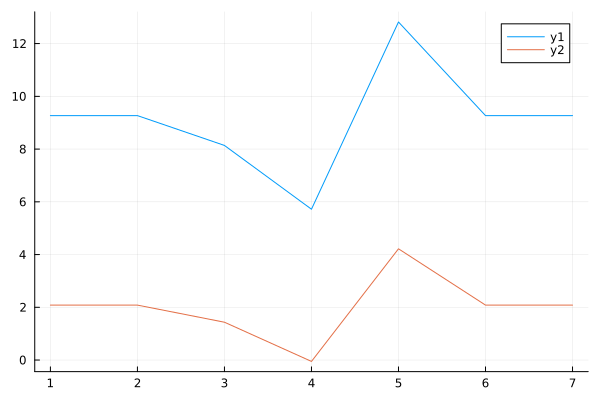

In [88]:
plot(u[:,1] .+ zVec)
plot!(zVec)

domain = Interval(0.0, 0.7000000000000001, 7, 0.0, 1.0, 0.1, Real[0.0, 0.11666666666666667, 0.23333333333333334, 0.35000000000000003, 0.4666666666666667, 0.5833333333333334, 0.7000000000000001], Real[-0.05, 0.06428571428571428, 0.17857142857142858, 0.29285714285714287, 0.4071428571428572, 0.5214285714285716, 0.6357142857142858, 0.7500000000000001], [2.0825259314878704; 2.0825259314878704; 1.4339087525718588; -0.052914596868381736; 4.217966459844122; 2.0825259314878704; 2.0825259314878704;;], nothing)
u = [7.186560951180244 -0.6053377815005707; 7.186560951180244 -0.6053377815005707; 6.703435020230119 2.5689670644130835; 5.771870988810534 -2.2647093497039816; 8.601250913549954 1.0540337867028402; 7.186560951180244 -0.6053377815005707; 7.186560951180244 -0.6053377815005707]
sol = optimize((gamma->begin
                #= c:\Users\marie\Documents\Cours\3ème_année\Stage\NumericalDiffusion\src\opt_diffusion.jl:436 =#
                J(optimFunctional, gamma, u_approx[end - 1], u_approx[end],

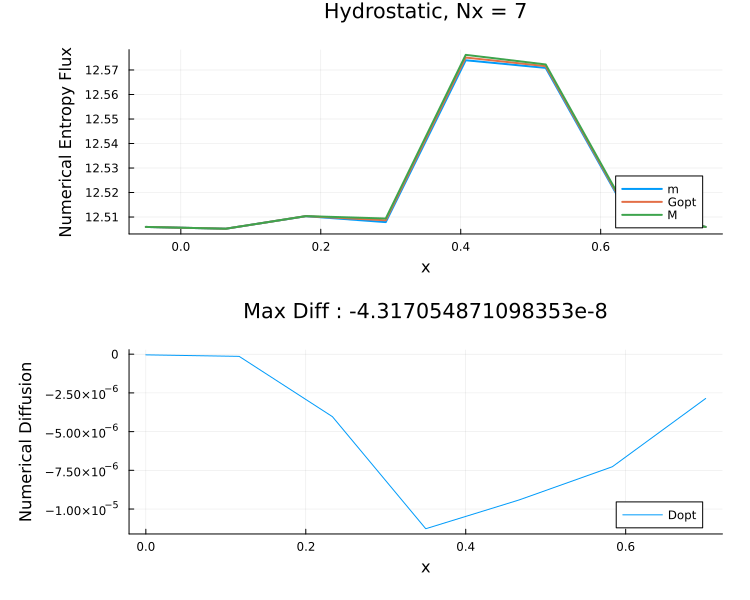

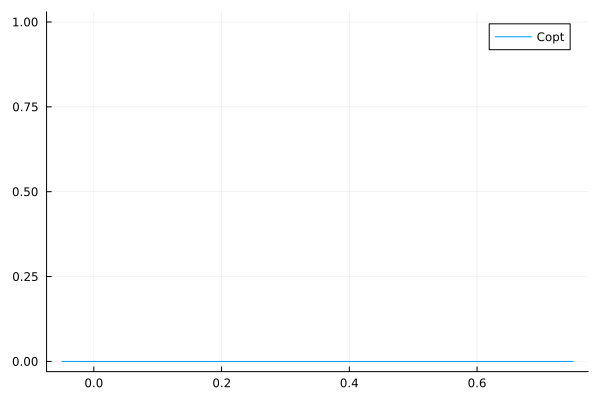

In [89]:
# Optimization process
@show domain 
@show u
solEnt = optimize_for_entropy(u, domain, equation, method)
plot_solution(solEnt)
plot(solEnt.domain.interfaces, solEnt.Copt, label="Copt")